In [1]:
from pickletools import optimize
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from tqdm import tqdm

from model import *
from utils import predict_transform, bbox_iou
from dataset import filter_labels, bbox_anchorbox_iou, draw_bbox, centre_dims_to_corners, DetectionDataset, Pad, ToTensor, Normalise
from loss import Yolo_Loss

plt.rcParams['figure.figsize'] = [15,15]

## Test Loss

### Load Data

In [2]:
label_dict = "D:/Datasets/bdd100k/labels/det_20/det_val.json"
root_dir = "D:/Datasets/bdd100k/images/100k/val"

In [3]:
mean = [92.11938007161459, 102.83839236762152, 104.90335580512152]
std = [66.09941202519124, 70.6808655565459, 75.05305001603533]
bs = 5

## load custom dataset + transforms
transformed_train_data = DetectionDataset(
    label_dict=label_dict,
    root_dir=root_dir,
    classes_file="data/bdd100k.names",
    grid_sizes=[13, 26, 52],
    anchors = np.array([
            [[116,90], [156,198], [373,326]],
            [[30, 61], [62, 45], [59,119]],
            [[10, 13], [16, 30], [33, 23]],
        ]),
    transform=transforms.Compose([
        Normalise(
            mean=mean,
            std=std
        ),
        Pad(416),
        ToTensor()
    ])
)

# separate into batches
train_loader = DataLoader(
    transformed_train_data,
    batch_size=bs,
    shuffle=True,
    num_workers=0
)

### Define Network

In [4]:
net = Net(cfgfile="cfg/model.cfg")

### Define Loss Function and Optimiser

In [5]:
criterion = Yolo_Loss()
optimizer = optim.SGD(net.parameters(), lr=0.0000001, momentum=0.9)

### Train Network

In [ ]:
CUDA = torch.cuda.is_available()

all_losses = []

for epoch in range(1): # each image gets 3 detections, this happens n_epoch times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        input_img, labels = data.values()

        #print(input_img.shape)
        optimizer.zero_grad()

        # forward pass
        outputs = net(input_img, CUDA)
        # compute loss
        loss = criterion(outputs, labels).float()
        
        # back prop        
        loss.backward()
        optimizer.step()

        # print stats
        running_loss +=loss.item()
        if i % bs == bs-1: # print every bs mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / bs:.3f}')
            all_losses.append(running_loss / bs)

            running_loss = 0.0

            #print(list(net.parameters())[0])

print("done")

## Save Weights and Plot Loss

In [18]:
torch.save(net.state_dict(), "weights/100_images.weights")

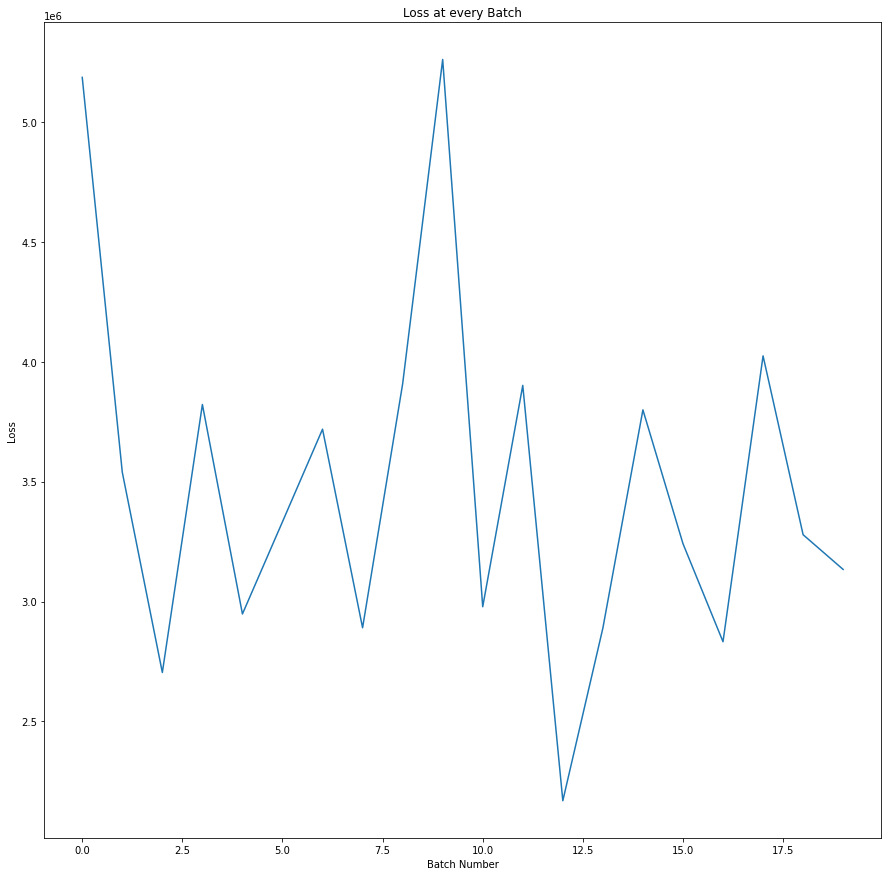

In [24]:
n_batch = np.arange(0, len(all_losses))
plt.plot(n_batch, all_losses)
plt.title("Loss at every Batch")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.show()

In [ ]:
# model = net()
# model.load_state_dict(torch.load("weights/100_images.weights"))
# model.eval()